In [1]:
import numpy as np
from numba import jit #関数の高速化のライブラリ
import matplotlib.pyplot as plt

## 不等流計算

In [2]:
@jit(nopython=True, parallel=False) # 高速化：デバッグ時は使わない方が良い
def nonuniformflow(q, hDB, zb, dx, manning, g=float(9.8)):
    h = np.zeros_like(zb) #水深の配列
    h[0] = hDB #下流端条件

    for i in range(1,len(h)):
    # newton法による反復計算
        # h[i] = h[i-1] + zb[i-1] - zb[i]#収束計算の初期値：一つ下流側の断面の水深
        # f = 1.0 #仮値
        # dfdh = 1.0 #仮値
        # while np.abs(f/dfdh) > 10**(-8): # 反復計算の収束条件
        #     f = q**2/2.0/g/h[i]**2 + h[i] + zb[i] \
        #       -(q**2/2.0/g/h[i-1]**2 + h[i-1] + zb[i-1]) \
        #       - 0.5*(q**2*manning**2/h[i]**(10/3) + q**2*manning**2/h[i-1]**(10/3))*dx
        #     dfdh = -q**2/g/h[i]**3 + 1 + 5/3*q**2*manning**2/h[i]**(13/3)*dx
        #     h[i] -= f/dfdh

    # 二分法による反復計算 : hcから徐々に上げていく
        hc = (q**2/g)**(1/3) # 限界水深 
        hp = hc
        E1 = q**2/2.0/g/hp**2 + hp + zb[i]
        E2 = + (q**2/2.0/g/h[i-1]**2 + h[i-1] + zb[i-1]) \
              + 0.5*(q**2*manning**2/hp**(10/3) + q**2*manning**2/h[i-1]**(10/3))*dx

        if E2 >= E1 : #常流時のみ計算, 射流時は限界水深に置き換え
        # 収束計算の初期値は限界水深+hmin:0.0001m
            hp += 0.0001
            dht = 0.1
            for _ in range(1000):
                E1 = q**2/2.0/g/hp**2 + hp + zb[i]
                E2 = + (q**2/2.0/g/h[i-1]**2 + h[i-1] + zb[i-1]) \
                      + 0.5*(q**2*manning**2/hp**(10/3) + q**2*manning**2/h[i-1]**(10/3))*dx
            
                if np.abs(E1 - E2) < 10**(-8): 
                    break
                elif E1 > E2 :
                    dht *= float(0.5)
                    hp -= dht
                else:
                    hp += dht
            else:
                print('error : max iteration - nonuniform flow sect No.', i, 'err=', np.abs(E1 - E2))

        h[i] = hp
        # print(h[i])
    return h

## 沈降速度式:rubeyの式

In [3]:
def rubeyw0(dd, nu=10**(-6)):
    rhosw = 1.65 # Specific gravity in water of sand 
    g = 9.8 # acceleration of gravity
    tmp = 36.0*nu**2/rhosw/g/dd**3
    F = np.sqrt(2.0/3.0 + tmp) - np.sqrt(tmp)
    
    return np.sqrt(rhosw*g*dd)*F

## 移動限界:岩垣の式

In [4]:
def iwagaki_org(d, g=9.8, Gw=1.65, nu=0.000001):
    #d:diameter[m]
    t = Gw*g*d**3/nu**2
    Rs = np.sqrt(t)
    
    R1, R2, R3, R4 = 671.0, 162.7, 54.2, 2.14
    Y1, Y2, Y3 = 0.05, 0.034, 0.14
    alpha1, beta1 = 0.008492171377400728, 0.13636363636363635
    alpha2, beta2 = 0.19514831719540923, -0.21875
    
    if Rs >= R1:
        taus = Y1
    elif Rs >= R2:
        taus = alpha1*t**beta1
    elif Rs >= R3:
        taus = Y2
    elif Rs >= R4:
        taus = alpha2*t**beta2
    else:
        taus = Y3
        
    return taus #, Rs*np.sqrt(taus)

## 基準面濃度式：岸・板倉式

In [5]:
@jit(nopython=True, parallel=False) # 高速化：デバッグ時は使わない方が良い
def erfc(xi):
    
    def erf(xi):
        x = np.abs(xi)
        
        t = 1/(1+0.5*x)
        
        tt = t*np.exp( -x**2    
        -1.26551223*t**0
        +1.00002368*t**1
        +0.37409196*t**2
        +0.09678418*t**3
        -0.18628806*t**4
        +0.27886807*t**5
        -1.13520398*t**6
        +1.48851587*t**7
        -0.82215223*t**8
        +0.17087277*t**9
          )
        
        return  1.0 - tt if xi >= 0.0 else tt-1.0
    
    return 1.0 - erf(xi)

@jit(nopython=True, parallel=False) # 高速化：デバッグ時は使わない方が良い
def caKishiKuroki(us, taus, w0, K = 0.0018, rhosw = float(1.65)):
    alfa = 0.14
    Bs = 0.143
    eta = 0.5
    
    def omega(taus):
        aprime = Bs/taus - 1.0/eta
        c1 = 0.5 / np.sqrt(np.pi) * np.exp(-aprime**2) 
        c2 = 0.5 * erfc(aprime)
        
        if c2 <= 0.0 :
            rr = 0.0
        else:
            rr =taus/Bs*c1/c2+ taus/Bs/eta - 1.0
        
        return rr 
    
    r = K*( alfa/(rhosw+1)*us/w0*omega(taus)/taus - 1.0 )
    
    return 0.0 if r < 0.0 else r

@jit(nopython=True, parallel=False) # 高速化：デバッグ時は使わない方が良い
def qsuca(q, h, manning, dm, w0, tausc, g = float(9.8), rhosw = float(1.65)):
    ca = np.zeros_like(h)
    for i in range(len(h)):
        us = np.sqrt(g)*manning*q/h[i]**(7/6) # 摩擦速度
        taus = us**2/rhosw/g/dm # 無次元掃流力
        if taus <= tausc :
            ca[i] = 0.0
        elif us/w0 < 1.0:
            ca[i] = 0.0
        else:
            ca[i] = caKishiKuroki(us, taus, w0)

    return ca

## 濃度の質量保存則の計算

In [6]:
@jit(nopython=True, parallel=False) # 高速化：デバッグ時は使わない方が良い
def calConcentration(q, h, w0, manning, Erosion, dx, g=float(9.8)):
    kappa=0.4 # カルマン定数
    # 濃度の連続式を計算
    c = np.zeros(len(Erosion)) 
    Deposition = np.zeros(len(Erosion)) 

    # 上端端境界 : 平衡状態
    i = 0
    us = np.sqrt(g)*manning*q/h[i]**(7/6) # 摩擦速度
    epsilon = kappa*us*h[i]/6.0
    A =  w0*h[i]/epsilon
    c[i] = Erosion[i]/w0/A*(1.0-np.exp(-A))
    Deposition[i] = Erosion[i]

    for i in range(1, len(c)):
        us = np.sqrt(g)*manning*q/h[i]**(7/6) # 摩擦速度
        epsilon = kappa*us*h[i]/6.0
        A =  w0*h[i]/epsilon
        c[i] = (q*c[i-1] + dx*Erosion[i])/(q + dx*w0*A/(1.0-np.exp(-A)))
        if c[i] < 0.0:print('濃度が負になりました', c[i], 'i=', i)
        Deposition[i] = w0*c[i]*A/(1.0-np.exp(-A))

    return c, Deposition

## 河床の連続式の計算

In [7]:
@jit(nopython=True, parallel=False) # 高速化：デバッグ時は使わない方が良い
def calzb(zb, qbhfp, Erosion, Deposition, dx, dt, porosity=0.4):
    # 河床の連続式を計算
    dzb = np.zeros(len(zb)) 
    for i in range(len(zb)):
        dzb[i] = - dt / (1.0 - porosity) * ( qbhfp[i+1] - qbhfp[i] )/dx \
                 - dt / (1.0 - porosity) * ( Erosion[i] - Deposition[i] )

    zb += dzb #zbの更新
    return zb, dzb

## main

### 計算条件の設定

In [8]:
q = 5.0 #単位幅流量[m^2/s]
manning = 0.02 #マニングの粗度係数
dm = 0.1/1000 #粒径[m]
dx = 100.0 #空間刻み[m] 
dt = 10.0 #時間刻み[s]

# 河床高の設定
ib = 1.0/700.0
L = np.arange(0,10000.01,dx) #追加距離の配列
zbr = L*ib #河床高の配列
zb  = zbr[::-1]

### 水理量のチェック

In [9]:
h0 = (q**2*manning**2/ib)**0.3 #等流水深
hc = (q**2/9.8)**(1/3) # 限界水深 
fr = q/h0/np.sqrt(9.8*h0)
taus = h0*ib/1.65/dm
tausc = iwagaki_org(dm)
w0 = rubeyw0(dm) # Rubeyの式による臨界流速
print('下流端条件-','水深：',h0, 'Froude数:' , fr,'\n', '無次元掃流力:', taus, '沈降速度:', w0, '移動限界:', tausc)

下流端条件- 水深： 1.792789962520997 Froude数: 0.6653694374950128 
 無次元掃流力: 15.521991017497811 沈降速度: 0.008395906310246372 移動限界: 0.10615965384825574


### 初期河床高を設定

In [10]:
# 河道中央付近にマウンドを設定
imd = len(zb)//2
zbsub = np.zeros_like(zb)
imd2 = imd+2
zbsub[imd:imd2] = 0.5 #中央付近の河床高に0.5mの凸を追加
zbsub[imd-1] = zbsub[imd2]   = 0.4 #擦り付け
zbsub[imd-2] = zbsub[imd2+1] = 0.3 #擦り付け
zbsub[imd-3] = zbsub[imd2+2] = 0.2 #擦り付け
zbsub[imd-4] = zbsub[imd2+3] = 0.1 #擦り付け

zb += zbsub #初期河床高

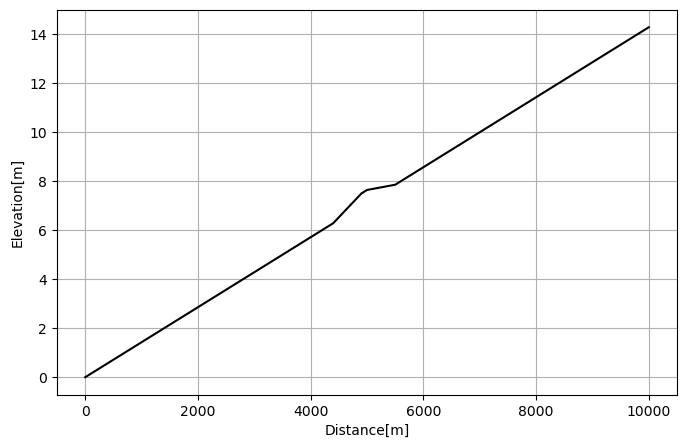

In [11]:
fig, ax = plt.subplots(figsize=(8, 5))

ax.plot(L, zb[::-1], label='zb', color='k')
ax.set_xlabel('Distance[m]')
ax.set_ylabel('Elevation[m]')
ax.grid()

### 河床変動計算

In [12]:
%%time
istep = int(1.0*3600.0/dt) #計算時間：ステップ数

zbini = zb.copy() #初期河床高の保存
c = np.zeros(len(zb)) #濃度の初期値
Erosion = np.zeros(len(zb)) #浸食量の初期値

for itr in range(istep):
    hDB = h0 #下流端の水深
    # hDB = float(12) #下流端の水深
    zbr = zb[::-1] #不等流計算用に逆順にする
    hr = nonuniformflow(q, hDB, zbr, dx, manning) # 不等流計算

    h = hr[::-1] #不等流計算結果が逆順になっているので元に戻す
    if itr==0: hini = h.copy() #初期水深の保存

    # 掃流砂量の計算 
    qbhf = np.zeros(len(h)+1) # 掃流砂量は0とする。

    # 浮遊砂の計算:巻き上げ量の計算
    caE = qsuca(q, h, manning, dm, w0, tausc) #巻き上げ量の基準面濃度の計算
    Erosion = w0*caE  # 浮遊砂の巻き上げ量

    # 濃度の更新、沈降量の計算
    c, Deposition = calConcentration(q, h, w0, manning, Erosion, dx) 

    #河床高の更新
    zb, d = calzb(zb, qbhf, Erosion, Deposition, dx, dt) 

CPU times: total: 281 ms
Wall time: 1.67 s


## 図化

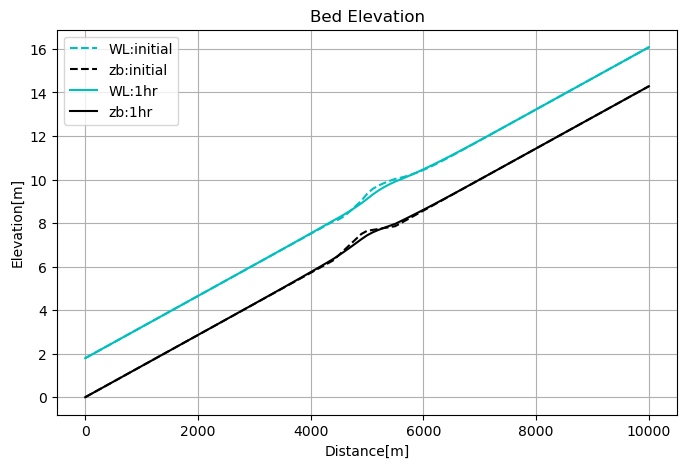

In [13]:
fig, ax = plt.subplots(figsize=(8, 5))

ax.plot(L, hini[::-1] + zbini[::-1], label='WL:initial', color='c', linestyle='dashed')
ax.plot(L, zbini[::-1], label='zb:initial', color='k', linestyle='dashed')
ax.plot(L, h[::-1] + zb[::-1], label='WL:1hr', color='c')
ax.plot(L, zb[::-1], label='zb:1hr', color='k')

ax.set_xlabel('Distance[m]')
ax.set_ylabel('Elevation[m]')
ax.set_title('Bed Elevation')
ax.grid(True)
ax.legend()